# Business Understanding

## Blocker Fraud Company

* The Blocker Fraud Company is a company specialized in detecting fraud in financial transactions made through mobile devices. The company has a service called “Blocker Fraud” with no guarantee of blocking fraudulent transactions.

* And the business model of the company is of the Service type with the monetization made by the performance of the service provided, that is, the user pays a fixed fee on the success in detecting fraud in the customer's transactions.

### Expansion Problem

Blocker Fraud Company is expanding in Brazil and to acquire customers more quickly, it has adopted a very aggressive strategy. The strategy works as follows:
1. The company will receive 25% of the value of each transaction that is truly detected as fraud.
1. The company will receive 5% of the value of each transaction detected as fraud, but the transaction is truly legitimate.
1. The company will return 100% of the value to the customer, for each transaction detected as legitimate, however the transaction is truly a fraud.

## The Challenge

You need to deliver to the CEO of Blocker Fraud Company a production model in which your access will be done via API, that is, customers will send their transactions via API so that your model classifies them as fraudulent or legitimate.

### Business Questions

1. What is the model's Precision and Accuracy?
1. How Reliable is the model in classifying transactions as legitimate or fraudulent?
1. What is the Expected Billing by the Company if we classify 100% of transactions with the model?
1. What is the Loss Expected by the Company in case of model failure?
1. What is the Profit Expected by the Blocker Fraud Company when using the model?

Data Source: https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset?resource=download

# Imports and Helper Functions

## Imports

In [1]:
import joblib
import warnings
import inflection
import time

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from scipy import stats
from boruta import BorutaPy
from category_encoders import OneHotEncoder

from IPython.display import Image
from IPython.core.display import HTML 

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics import recall_score, f1_score, make_scorer, cohen_kappa_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold


#from churn.Churn import Churn
from flask import Flask, request, Response


import requests

## Helper Functions

In [2]:
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

In [3]:
#This function is for defining display settings for jupyter notebook

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    sns.set(font_scale=1.6)
    
    plt.style.use('seaborn-darkgrid')
    plt.rcParams['figure.figsize'] = [15, 7]
    #plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
#This function is used for calculating the accuracy, precision, recall, f1 score and kappa values and returning the result as a dataframe

def ml_scores(model_name, y_true, y_pred):
    
    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)}, 
                        index=[model_name])

In [5]:
# This function is used for calculating the Cramér's V values. 
##Cramér's V is an effect size measurement for the chi-square test of independence. It measures how strongly two categorical fields are associated.

def calcCramerV(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [6]:
#This function is used to perform specific operations such as data normalization, cross validation, splitting the model in train and test sets and showing the accuracy, 
##precision, recall, f1 score and kappa values.

def ml_cv_results(model_name, model, x, y, verbose=1):
    
    '''initial'''
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1s = []
    kappas = []
    
    mm = MinMaxScaler()
    
    x_ = x.to_numpy()
    y_ = y.to_numpy()
    
    count = 0
    
    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    for index_train, index_test in skf.split(x_, y_):
        ## Showing the Fold
        if verbose > 0:
            count += 1
            print('Fold K=%i' % (count))
    
        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]
        
        ## applying the scale
        x_train = mm.fit_transform(x_train)
        x_test = mm.transform(x_test)
    
        ## training the model
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        ## saving the metrics
        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        kappas.append(cohen_kappa_score(y_test, y_pred))
        
        
    '''results'''    
    accuracy_mean, accuracy_std = np.round(np.mean(balanced_accuracies), 3), np.round(np.std(balanced_accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    kappa_mean, kappa_std = np.round(np.mean(kappas), 3), np.round(np.std(kappas), 3)
    
    ## saving the results in a dataframe
    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std),
                        "Kappa": "{} +/- {}".format(kappa_mean, kappa_std)},
                       index=[model_name])

# 1.0 Data Description

## 1.1 Loading Data

In [7]:
#loading the data using pandas. To ease computation, only 10% of the original data were used for this study as the number of records in the data are 6,362,620
df1 = pd.read_csv('fraud_data.csv') 

In [8]:
df1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,0,0
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,0,0
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,0,0
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,0,0
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,0,0


>*The table above shows the first five records of transactions the dataset.*

In [9]:
df1.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
636257,351,CASH_OUT,28761.10,C742050657,0.0,0.00,C568407561,328534.52,357295.62,0,0
636258,184,CASH_OUT,167820.71,C561181412,62265.0,0.00,C1852953580,106429.48,274250.18,0,0
636259,35,PAYMENT,8898.12,C1773417333,30808.0,21909.88,M445701551,0.00,0.00,0,0
636260,277,CASH_OUT,176147.90,C1423233247,83669.0,0.00,C1328739120,0.00,176147.90,0,0
636261,304,CASH_OUT,95142.89,C874575079,0.0,0.00,C666451134,431380.07,526522.96,0,0


>*The table above shows the last five records of transactions in the dataset.*

## 1.2 Columns

### 1.2.1 Column Descriptions

**step:** maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 742 (30 days simulation).

**type:** CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount:** amount of the transaction in local currency.

**nameOrig:** customer who started the transaction

**oldbalanceOrg:** initial balance before the transaction

**newbalanceOrig:** new balance after the transaction

**nameDest:** customer who is the recipient of the transaction

**oldbalanceDest:** initial balance of recipients before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest:** new balance of recipients after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud:** This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud:** The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

### 1.2.2 Column Rename

In [10]:
#Renaming the columns in the dataset
cols_old = df1.columns.tolist()

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [11]:
df1.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

## 1.3 Data Dimension

In [12]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 636262
Number of Cols: 11


## 1.4 Data Types and Structure

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636262 entries, 0 to 636261
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   step              636262 non-null  int64  
 1   type              636262 non-null  object 
 2   amount            636262 non-null  float64
 3   name_orig         636262 non-null  object 
 4   oldbalance_org    636262 non-null  float64
 5   newbalance_orig   636262 non-null  float64
 6   name_dest         636262 non-null  object 
 7   oldbalance_dest   636262 non-null  float64
 8   newbalance_dest   636262 non-null  float64
 9   is_fraud          636262 non-null  int64  
 10  is_flagged_fraud  636262 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 53.4+ MB


## 1.5 Check NA

In [14]:
df1.isna().mean()

step                0.0
type                0.0
amount              0.0
name_orig           0.0
oldbalance_org      0.0
newbalance_orig     0.0
name_dest           0.0
oldbalance_dest     0.0
newbalance_dest     0.0
is_fraud            0.0
is_flagged_fraud    0.0
dtype: float64

## 1.6 Fill Out NA

There's no NaN values to fill.

## 1.7 Change Data Type

 I will change the values 0 and 1 to 'yes' and 'no'. It'll help on the data description and analysis sections.

In [15]:
df1['is_fraud'] = df1['is_fraud'].map({1: 'yes', 0: 'no'})
df1['is_flagged_fraud'] = df1['is_flagged_fraud'].map({1: 'yes', 0: 'no'})

## 1.8 Description Statistics

In [16]:
num_attributes = df1.select_dtypes(exclude='object') #selecting the numerical variables
cat_attributes = df1.select_dtypes(include='object') #selecting the categorical variables

### 1.8.1 Numerical Attributes

In [17]:
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
step,636262.0,2.429319e+02,1.423309e+02,1.0,155.000,238.000,3.340000e+02,7.420000e+02,7.410000e+02,0.585888,0.375052,0.324437
amount,636262.0,1.800585e+05,6.069714e+05,0.0,13407.425,74815.770,2.084988e+05,5.722962e+07,5.722962e+07,3.370967,29.577107,1546.661043
oldbalance_org,636262.0,8.317937e+05,2.885636e+06,0.0,0.000,14239.000,1.072998e+05,4.368662e+07,4.368662e+07,3.469173,5.243428,32.766036
newbalance_orig,636262.0,8.528354e+05,2.921296e+06,0.0,0.000,0.000,1.435652e+05,4.367380e+07,4.367380e+07,3.425393,5.173614,31.932547
oldbalance_dest,636262.0,1.096212e+06,3.375389e+06,0.0,0.000,131539.745,9.384820e+05,3.551855e+08,3.551855e+08,3.079138,20.622388,1074.335293
newbalance_dest,636262.0,1.221809e+06,3.656213e+06,0.0,0.000,214712.725,1.109230e+06,3.555534e+08,3.555534e+08,2.992460,19.623903,928.694204


* All the data has a coefficient of variation greater than 25%, therefore they aren't homogeneous.

* The step variable starts from 1 hour to 742 hour (30 days).

* Some variables have higher shap values and are right skewed.

* 50% of the newbalance_orig is 0. Maybe there are some transfers that don't go to the destination.

* The skew is higher positive, therefore the values may be in less values.

### 1.8.2 Categorical Attributes

In [18]:
cat_attributes.describe()

,type,name_orig,name_dest,is_fraud,is_flagged_fraud
count,636262,636262,636262,636262,636262
unique,5,636171,457224,2,2
top,CASH_OUT,C334643493,C2083562754,no,no
freq,224216,2,14,635441,636260


* The majority type is cash_out with 224,216.

* There's a lot of variability in name_orig, so it could be hard to use one hot encoding.

* There are more name_orig than name_dest. There are more users sending than receiving, however use one hot encoding will not help.

* There's more fraud than the flagged fraud, it shows that the current method can't recognize fraud efficiently.

# 2.0 Feature Engineering

In [19]:
df2 = df1.copy()

## 2.1 Mind Map

In [20]:
#Image('../images/Fraud-mindmap.png')

## 2.2 Feature Engineering

In [21]:
# step
df2['step_days'] = df2['step'].apply(lambda i: i/24)  #converting hour to day
df2['step_weeks'] = df2['step'].apply(lambda i: i/(24*7)) #converting hour to week

# difference between initial balance before the transaction and new balance after the transaction
df2['diff_new_old_balance'] = df2['newbalance_orig'] - df2['oldbalance_org']

# difference between initial balance recipient before the transaction and new balance recipient after the transaction.
df2['diff_new_old_dest'] = df2['newbalance_dest'] - df2['oldbalance_dest']

# name orig and name dest
df2['name_orig'] = df2['name_orig'].apply(lambda i: i[0])
df2['name_dest'] = df2['name_dest'].apply(lambda i: i[0])

# 3.0 Selecting Columns

In [22]:
df3 = df2.copy()

## 3.1 Selecting Columns

All the columns will be used for data analysis

# 4.0 Exploratory Data Analysis

In [23]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

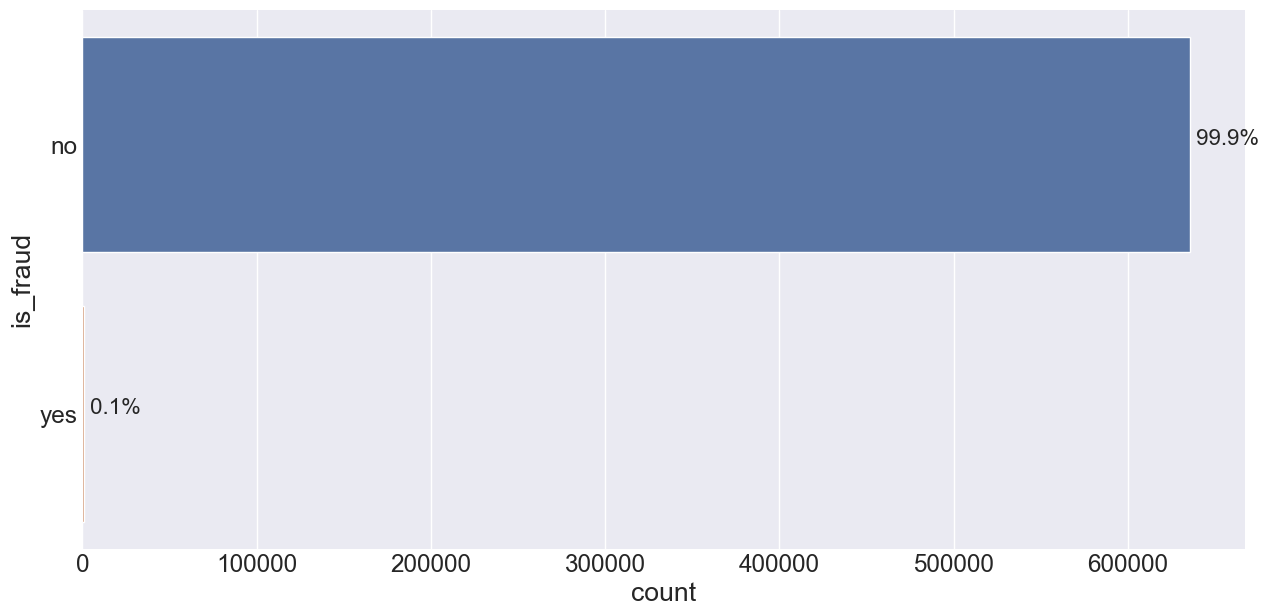

In [24]:
ax = sns.countplot(y='is_fraud', data=df4);

total = df4['is_fraud'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

>*The chart above shows that 99.9% of transactions recorded are not fraudulent while 0.1% are fraudulent*

### 4.1.2 Numerical Variables

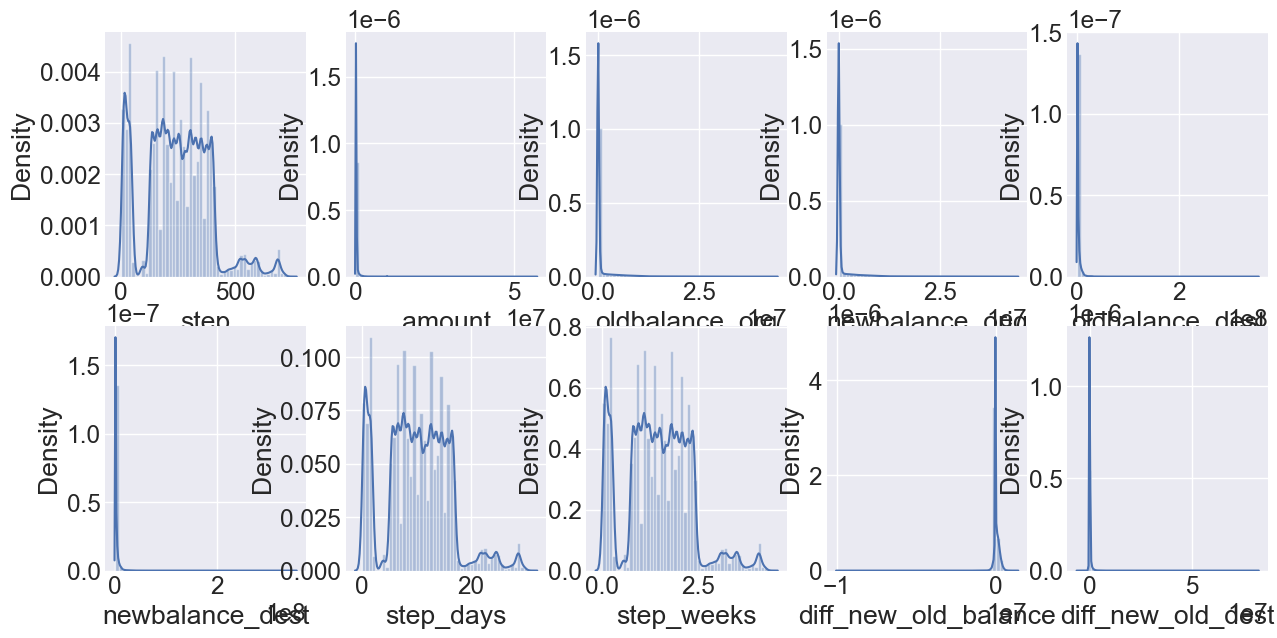

In [25]:
num_attributes = df4.select_dtypes(exclude='object')
columns = num_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(2, 5, j)
    sns.distplot(num_attributes[column]);
    
    j += 1

>*The chart above shows the distribution plot of the numerical variables in the dataset. It can be seen that most of them are right skewed.*

### 4.1.3 Categorical Variables

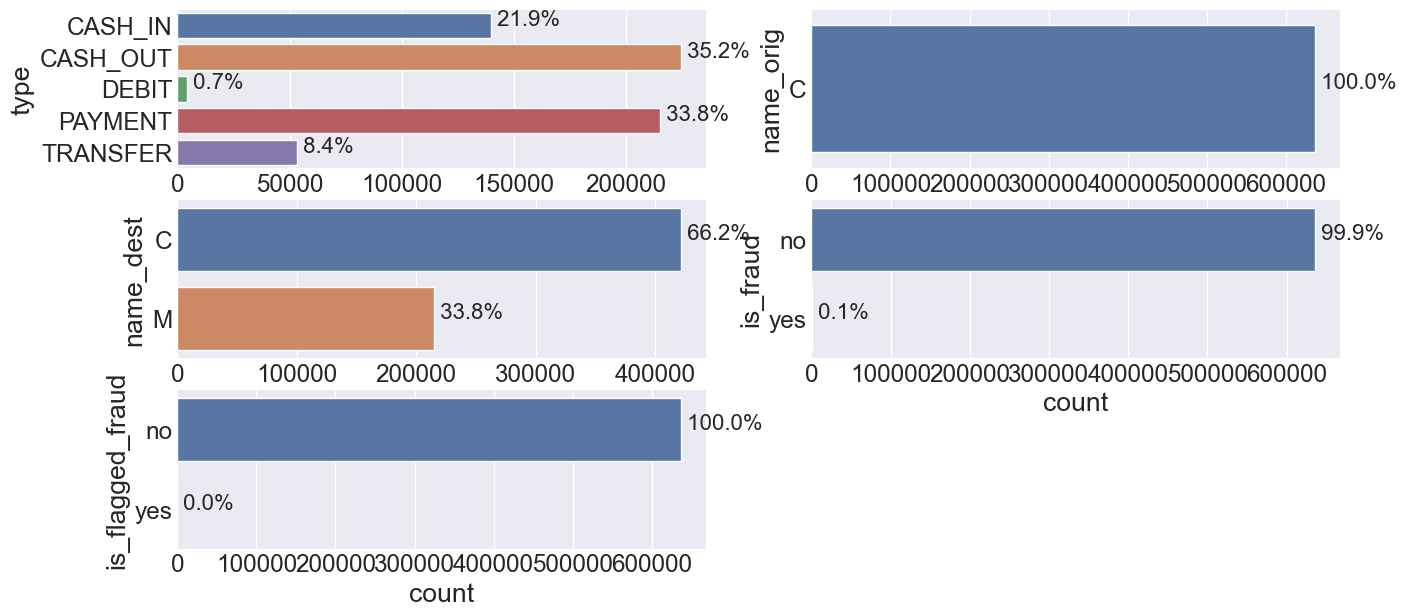

In [26]:
cat_attributes = df4.select_dtypes(include='object')
columns = cat_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(3, 2, j)
    ax = sns.countplot(y=column, data=cat_attributes)
    
    total = cat_attributes[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    
    j += 1

>*The chart above shows most of the transactions carried out are of the payment type, while there are more "Customer" type of funds receiver than the "Merchant" type. For name origin; all the transactions were initiated by the customers. The system wasn't able to flag any fraudulent transaction while we have 0.1% of fraudulent transactions recorded.*

## 4.2 Bivariate Analysis

### The majority of fraud transactions occur for the same user.
The same user origin and destination has got the same initial letter.

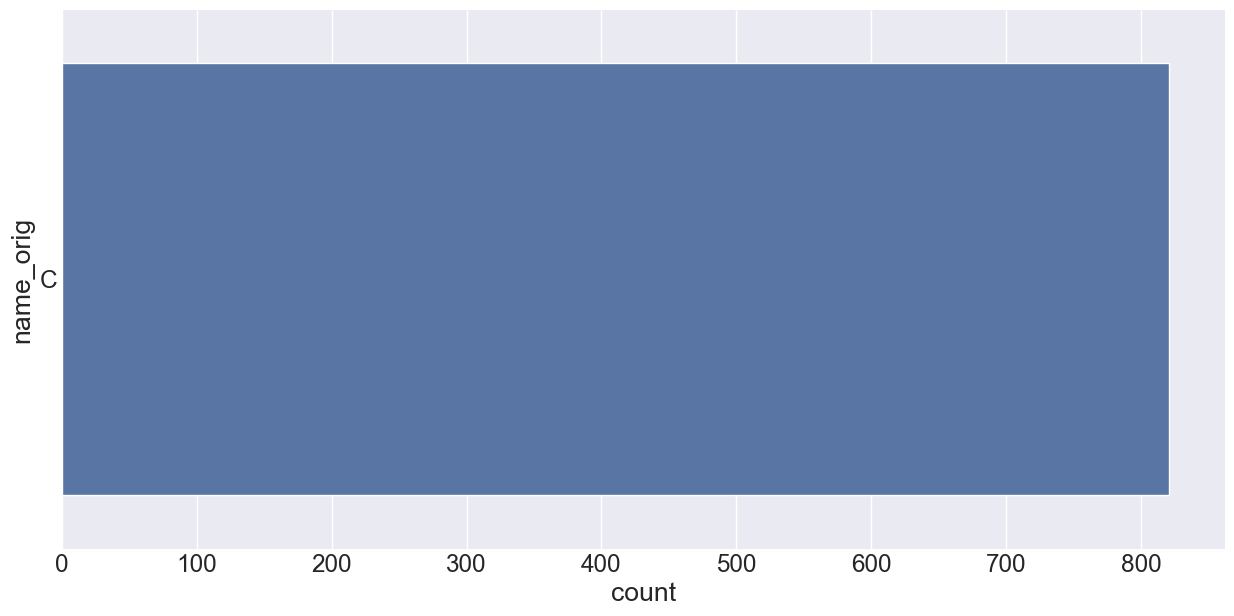

In [27]:
aux1 = df4[df4['is_fraud'] == 'yes']
sns.countplot(y='name_orig', data=aux1);

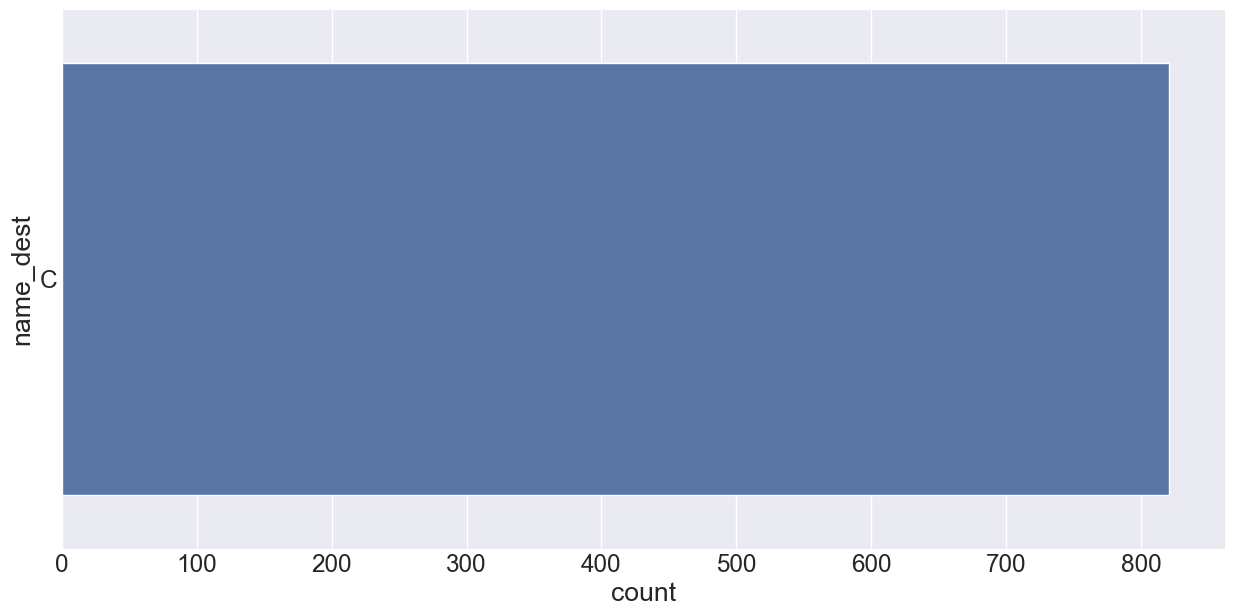

In [28]:
sns.countplot(y='name_dest', data=aux1);

### All the fraud amount is greater than 10.000.

The values are greater than 10.000. But it's important to note that the no-fraud values is greater than 100.000 also.

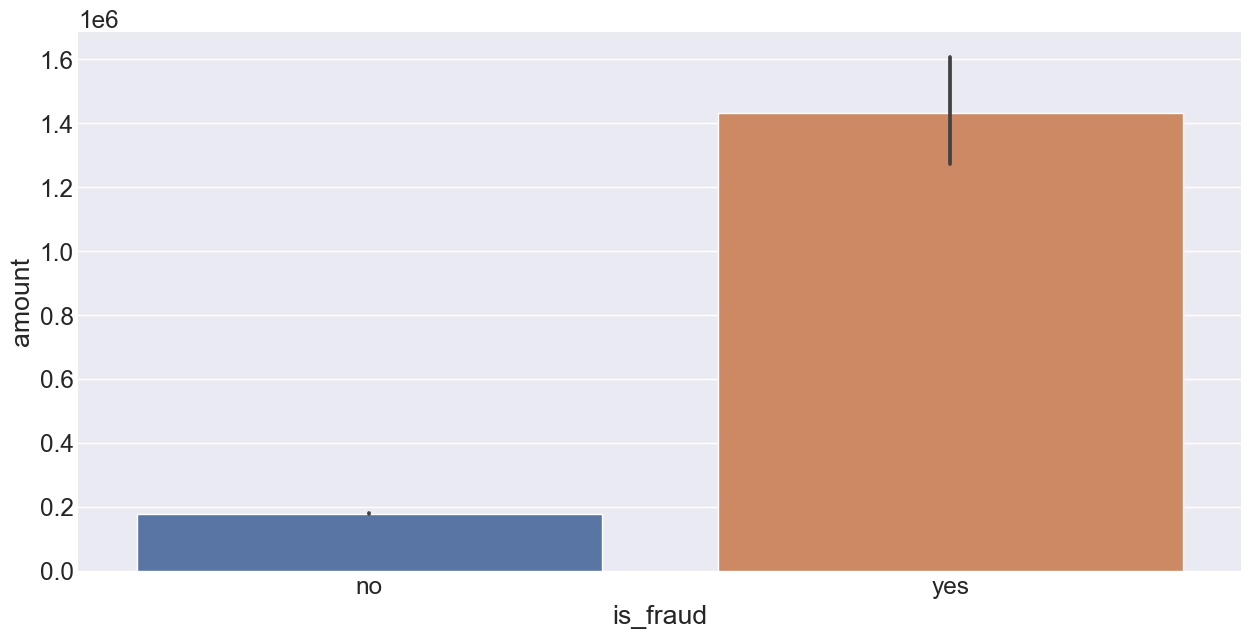

In [29]:
sns.barplot(y='amount', x='is_fraud', data=df4);

### 49.6% of fraud transaction occur using cash-out-type method.

The fraud transactions occur in transfer and cash-out type. However they're almost the same value.

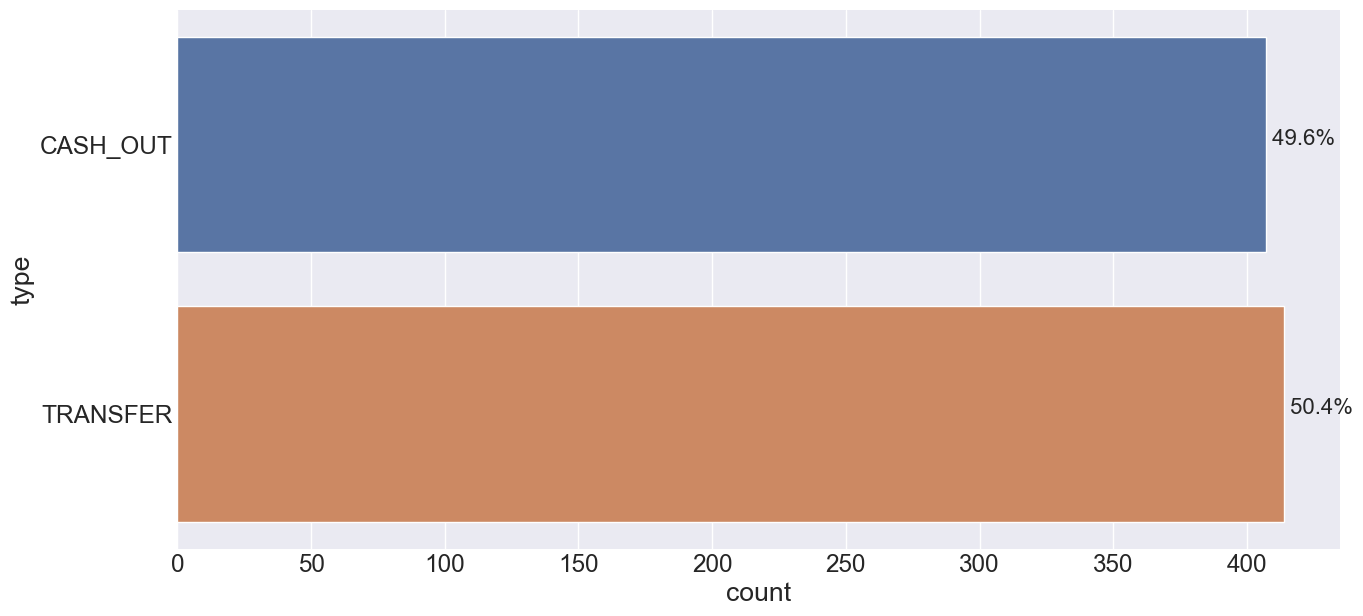

In [30]:
aux1 = df4[df4['is_fraud'] == 'yes']
ax = sns.countplot(y='type', data=aux1)

total = aux1['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

To see the complete transaction-type, I'll plot them here.

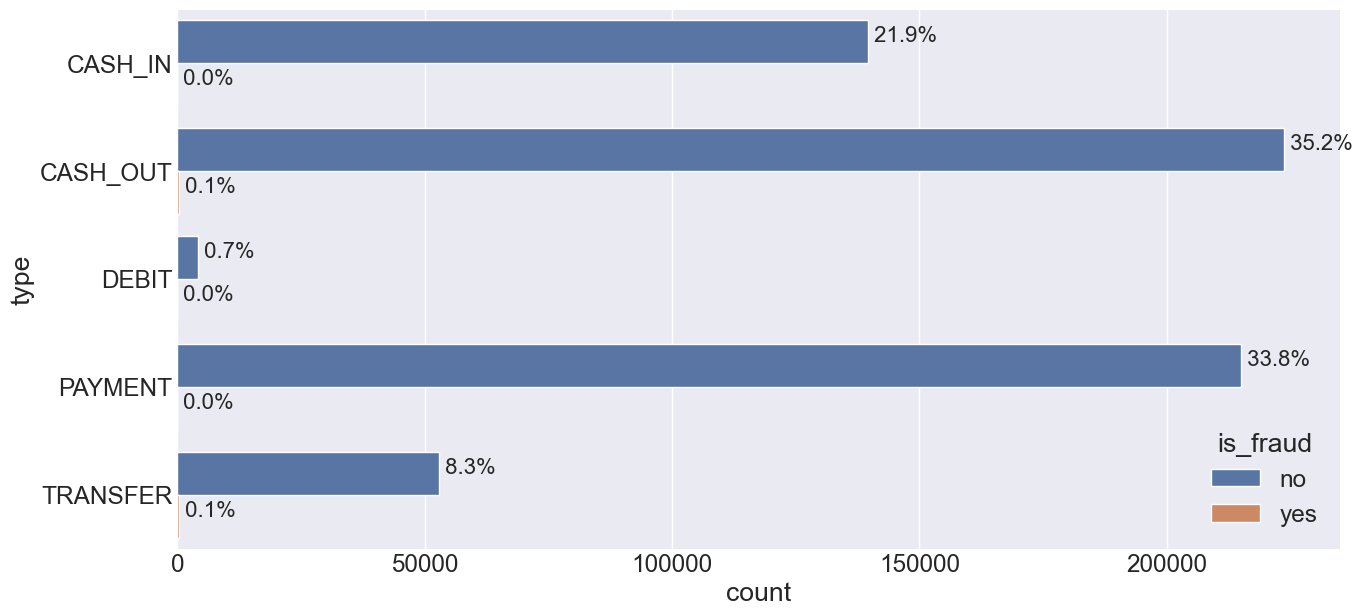

In [31]:
ax = sns.countplot(y='type', hue='is_fraud', data=df4)

total = df4['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

###  Amount greater than 100.000 occur using transfer-type method.

The majority of transactions occur in transfer-type, however transactions greater than 100.000 occur in cash-out and cash-in too.

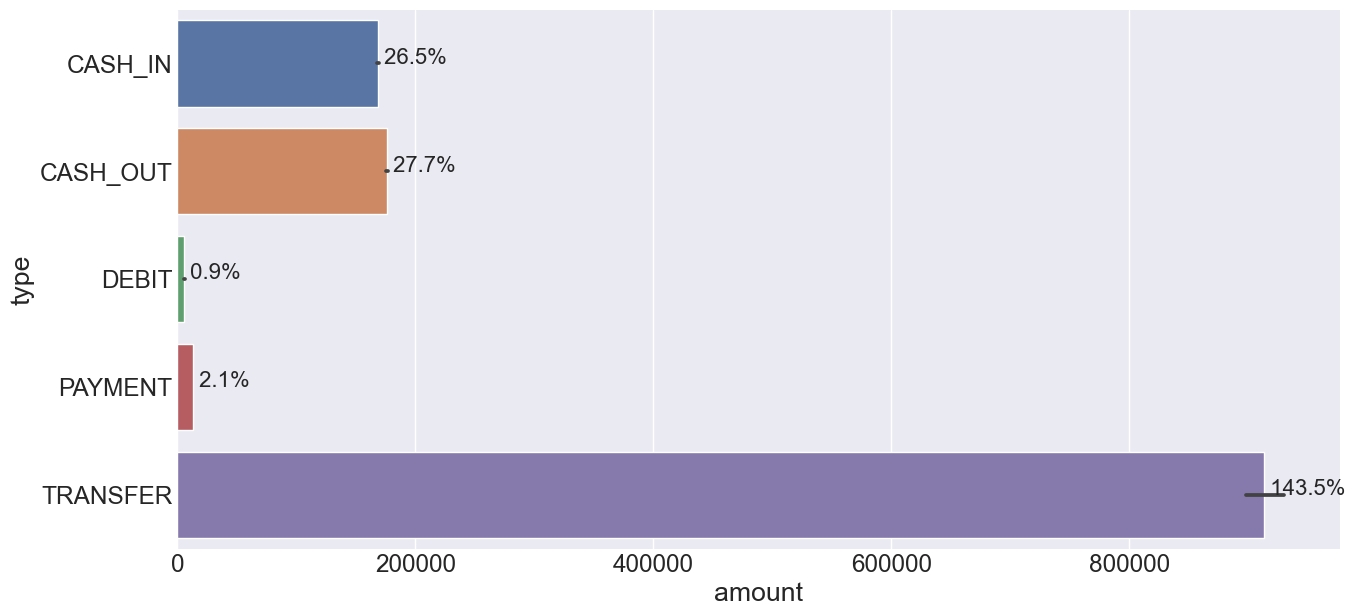

In [32]:
ax = sns.barplot(y='type', x='amount', data=df4);

total = df4['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### Fraud transactions occur at least in 3 days.

The values for transactions and days in fraud aren't similar.

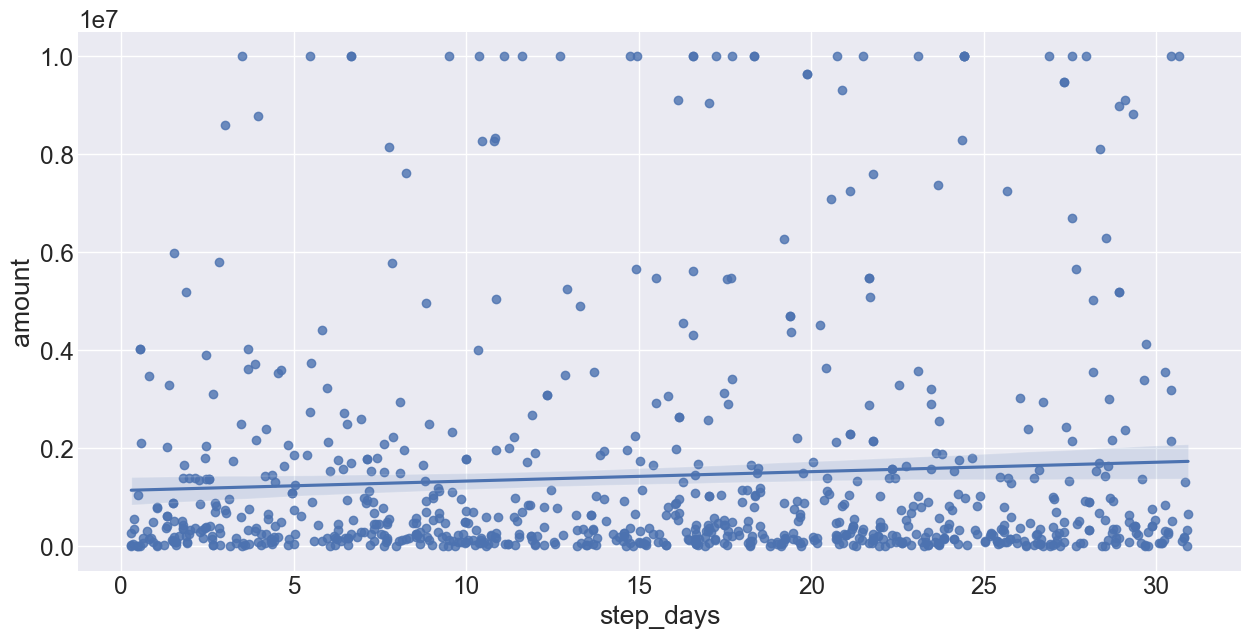

In [33]:
aux1 = df4[df4['is_fraud'] == 'yes']
sns.regplot(x='step_days', y='amount', data=aux1);

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Analysis

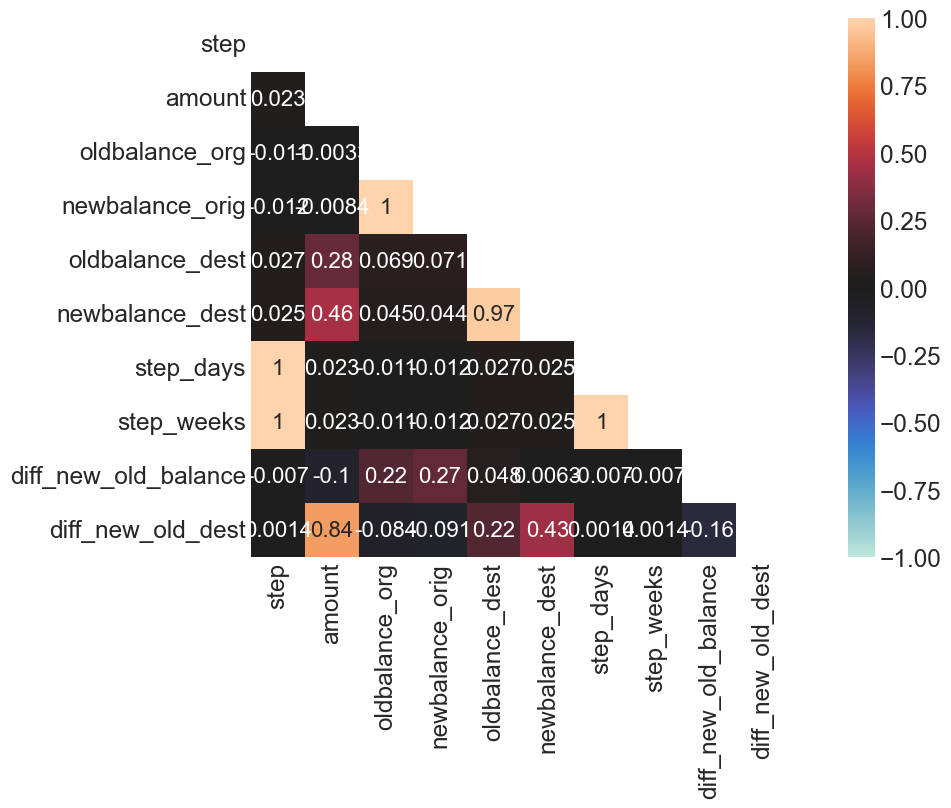

In [34]:
corr = num_attributes.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True)

### 4.3.2 Categorical Variables

In [35]:
dict_corr = {}
columns = cat_attributes.columns.tolist()

for column in columns:
    dict_corr[column] = {}
    
    for column2 in columns:
        dict_corr[column][column2] = calcCramerV(cat_attributes[column], cat_attributes[column2])
        
corr = pd.DataFrame(dict_corr)

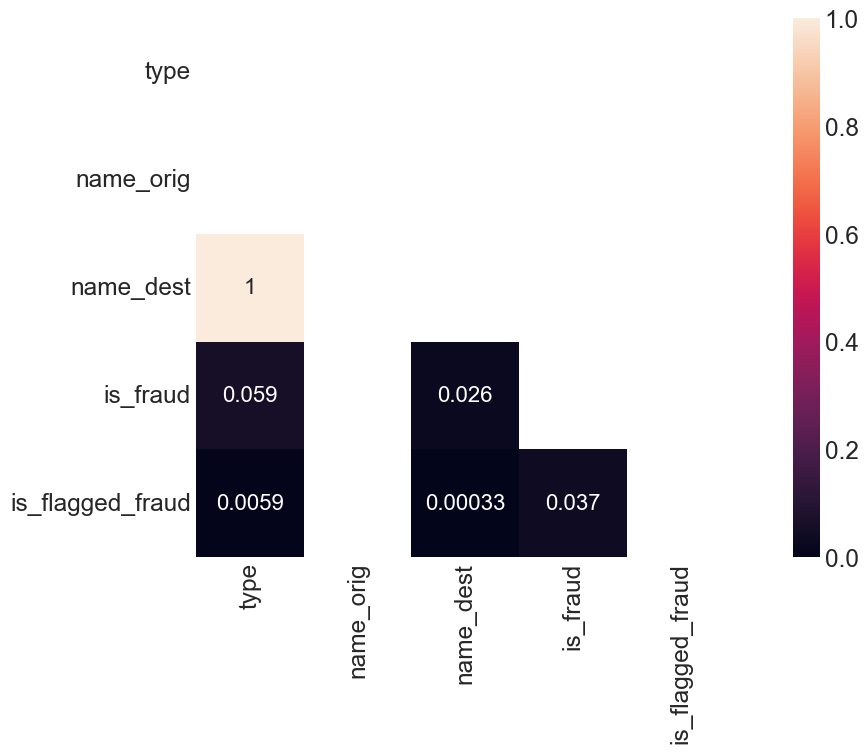

In [36]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

# 5.0 Data Preparation

In [37]:
df5 = df4.copy()

## 5.1 Spliting into Train, Valid and Test

In [38]:
X = df5.drop(columns=['is_fraud', 'is_flagged_fraud', 'name_orig', 'name_dest', 
                      'step_weeks', 'step_days'], axis=1) #independent variables
y = df5['is_fraud'].map({'yes': 1, 'no': 0}) #dependent/target variable

In [39]:
# spliting into temp and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [40]:
# spliting into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.2, stratify=y_temp)

In [41]:
print('Training : ', X_train.shape)
print('Validation : ', X_valid.shape)
print('Test : ', X_test.shape)

Training :  (407207, 9)
Validation :  (101802, 9)
Test :  (127253, 9)


>*The data was splitted into 64% training data, 16% validation data and 20% test data.*

## 5.2 One Hot Encoder

In [42]:
# One-hot encoding can be used to transform one or more categorical features into numerical dummy features useful for training machine learning model. 
## One-hot encoding is also called dummy encoding due to the fact that the transformation of categorical features results into dummy features. 

ohe = OneHotEncoder(cols=['type'], use_cat_names=True)

X_train = ohe.fit_transform(X_train)
X_valid = ohe.transform(X_valid)

X_temp = ohe.fit_transform(X_temp)
X_test = ohe.transform(X_test)

## 5.3 Rescaling

In [43]:
# The MinMax Scaler shrinks the data within the given range, usually of 0 to 1. 
## It transforms data by scaling features to a given range. It scales the values to a specific value range without changing the shape of the original distribution.

num_columns = ['amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest', 'newbalance_dest',
               'diff_new_old_balance', 'diff_new_old_dest']
mm = MinMaxScaler()
X_params = X_temp.copy()

X_train[num_columns] = mm.fit_transform(X_train[num_columns])
X_valid[num_columns] = mm.transform(X_valid[num_columns])

X_params[num_columns] = mm.fit_transform(X_temp[num_columns])
X_test[num_columns] = mm.transform(X_test[num_columns])

# 6.0 Feature Selection

## 6.1 Boruta

Boruta is a Python package designed to take the “all-relevant” approach to feature selection. Feature selection is one of the most crucial and time-consuming phases of the machine learning process, second only to data cleaning. After applying the feature selection process, the relevant features selected using Boruta are step, oldbalance_org, newbalance_orig,
newbalance_dest, diff_new_old_balance, diff_new_old_dest and type_TRANSFER.

In [44]:
#X_boruta = X_params.values
#y_boruta = y_temp.values.ravel()

In [45]:
#boruta = BorutaPy(RandomForestClassifier(), n_estimators='auto')
#boruta.fit(X_boruta, y_boruta)

### 6.1.1 Best Features

In [46]:
#cols_selected_boruta = boruta.support_.tolist()

In [47]:
#columns_selected = X_params.loc[:, cols_selected_boruta].columns.tolist()

In [48]:
#columns_selected

In [49]:
# ['step',
#  'amount',
#  'oldbalance_org',
#  'newbalance_orig',
#  'oldbalance_dest',
#  'newbalance_dest',
#  'diff_new_old_balance',
#  'diff_new_old_dest',
#  'type_TRANSFER']

In [50]:
final_columns_selected = ['step', 'oldbalance_org', 
                          'newbalance_orig', 'newbalance_dest', 
                          'diff_new_old_balance', 'diff_new_old_dest', 
                          'type_TRANSFER']

# 7.0 Machine Learning Modeling

In [51]:
X_train_cs = X_train[final_columns_selected]
X_valid_cs = X_valid[final_columns_selected]

X_temp_cs = X_temp[final_columns_selected]
X_test_cs = X_test[final_columns_selected]

X_params_cs = X_params[final_columns_selected]

## 7.1 Baseline

The baseline model is carried out using Dummy Classifier. It is a classifier model that makes predictions without trying to find patterns in the data. The default model essentially looks at what label is most frequent in the training dataset and makes predictions based on that label

In [52]:
dummy = DummyClassifier()
dummy.fit(X_train_cs, y_train)

y_pred = dummy.predict(X_valid_cs)

In [53]:
dummy_results = ml_scores('dummy', y_valid, y_pred)
dummy_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.5,0.0,0.0,0.0,0.0


>*The Dummy Classifier returns a balanced accuracy score of 50% and zero values for precision, recall, f1 and kappa*

### 7.1.1 Classification Report

In [54]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.00      0.00      0.00       131

    accuracy                           1.00    101802
   macro avg       0.50      0.50      0.50    101802
weighted avg       1.00      1.00      1.00    101802



>*The Dummy Classifier performs poorly in classifying fraudulent transactions with an f1 score of 0.*

### 7.1.2 Cross Validation

Cross-validation is a technique for evaluating ML models by training several ML models on subsets of the available input data and evaluating them on the complementary subset of the data. Cross-validation is used to detect overfitting. For all models, the data was splitted into 5 folds.

In [55]:
dummy_cv = ml_cv_results('Dummy', DummyClassifier(), X_temp, y_temp)
dummy_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0


>*There isn't a significant improvement in the results of the evaluation metrics after performing cross validation.*

## 7.2 Logistic Regression

In [56]:
lg = LogisticRegression()
lg.fit(X_train_cs, y_train)

y_pred = lg.predict(X_valid_cs)

In [57]:
lg_results = ml_scores('Logistic Regression', y_valid, y_pred)
lg_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.584,1.0,0.168,0.288,0.287


>*The logistc regression model returns a balanced accuracy score of 58.4% and 1.0, 0.168, 0.288 and 0.287 for precision, recall, f1 and kappa respectively.*

### 7.2.1 Classification Report

In [58]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       1.00      0.17      0.29       131

    accuracy                           1.00    101802
   macro avg       1.00      0.58      0.64    101802
weighted avg       1.00      1.00      1.00    101802



>*The logistic regression performs poorly in classifying fraudulent transactions with an f1 score of 0.29.*

### 7.2.2 Cross Validation

In [59]:
lg_cv = ml_cv_results('Logistic Regression',
                      LogisticRegression(), 
                      X_temp_cs, y_temp)
lg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.565 +/- 0.013,1.0 +/- 0.0,0.129 +/- 0.026,0.228 +/- 0.041,0.228 +/- 0.041


>*After applying cross validaion, there was only a little improvement in the accuracy score. The precision, recall, f1 and kappa scores returned from the cross validation process are more reliable and can be accepted as the actual performance of the model.*

## 7.3 K Nearest Neighbors

In [60]:
knn = KNeighborsClassifier()
knn.fit(X_train_cs, y_train)

y_pred = knn.predict(X_valid_cs)

In [61]:
knn_results = ml_scores('K Nearest Neighbors', y_valid, y_pred)
knn_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.565,1.0,0.13,0.23,0.23


>*The KNN model returns a balanced accuracy score of 56.5% and 1.0, 0.13, 0.23 and 0.23 for precision, recall, f1 and kappa respectively.*

### 7.3.1 Classification Report

In [62]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       1.00      0.13      0.23       131

    accuracy                           1.00    101802
   macro avg       1.00      0.56      0.61    101802
weighted avg       1.00      1.00      1.00    101802



>*The KNN model performs poorly in classifying fraudulent transactions with an f1 score of 0.23.*

### 7.3.2 Cross Validation

In [63]:
knn_cv = ml_cv_results('K Nearest Neighbors', KNeighborsClassifier(), 
                       X_temp_cs, y_temp)
knn_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.705 +/- 0.017,0.943 +/- 0.033,0.411 +/- 0.034,0.572 +/- 0.038,0.572 +/- 0.038


>*The balanced accuracy, precision, recall, f1 and kappa scores after applying cross validation to the KNN model are: 70.5%, 0.943, 0.411, 0.572 and 0.572 respectively.*

## 7.4 Support Vector Machine

In [64]:
svm = SVC()
svm.fit(X_train_cs, y_train)

y_pred = svm.predict(X_valid_cs)

In [65]:
svm_results = ml_scores('SVM', y_valid, y_pred)
svm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.5,0.0,0.0,0.0,0.0


>*The SVM model returns a balanced accuracy score of 0.5% and zero values for precision, recall, f1 and kappa respectively. The SVM has a very poor performance on this data.*

### 7.4.1 Classification Report

In [66]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.00      0.00      0.00       131

    accuracy                           1.00    101802
   macro avg       0.50      0.50      0.50    101802
weighted avg       1.00      1.00      1.00    101802



>*The SVM model performs poorly in classifying fraudulent transactions with an f1 score of 0.00.*

### 7.4.2 Cross Validation

In [67]:
svm_cv = ml_cv_results('SVM', SVC(), X_temp_cs, y_temp)
svm_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.596 +/- 0.017,1.0 +/- 0.0,0.192 +/- 0.034,0.32 +/- 0.047,0.32 +/- 0.047


>*The balanced accuracy, precision, recall, f1 and kappa scores after applying cross validation to the SVM model are: 59.6%, 1.0, 0.192, 0.32 and 0.32 respectively.*

## 7.5 Random Forest

In [68]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_cs, y_train)

y_pred = rf.predict(X_valid_cs)

In [69]:
rf_results = ml_scores('Random Forest', y_valid, y_pred)
rf_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.844,0.978,0.687,0.807,0.807


>*The Random Forest model returns a balanced accuracy score of 0.84% and 0.978, 0.687, 0.807, 0.807 for precision, recall, f1 and kappa respectively. The Random Forest has a better performance on this data.*

### 7.5.1 Classification Report

In [70]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.98      0.69      0.81       131

    accuracy                           1.00    101802
   macro avg       0.99      0.84      0.90    101802
weighted avg       1.00      1.00      1.00    101802



>*The Random Forest model has a good performance in classifying fraudulent transactions with an f1 score of 0.81.*

### 7.5.2 Cross Validation

In [71]:
rf_cv = ml_cv_results('Random Forest', 
                      RandomForestClassifier(), 
                      X_temp_cs, y_temp)
rf_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.861 +/- 0.019,0.969 +/- 0.018,0.721 +/- 0.038,0.827 +/- 0.029,0.827 +/- 0.029


>*The balanced accuracy, precision, recall, f1 and kappa scores after applying cross validation to the Random Forest model are: 86.1%, 0.97, 0.72, 0.83 and 0.83 respectively.*

## 7.6 XGBoost

In [72]:
xgb = XGBClassifier()
xgb.fit(X_train_cs, y_train)

y_pred = xgb.predict(X_valid_cs)

In [73]:
xgb_results = ml_scores('XGBoost', y_valid, y_pred)
xgb_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.866,0.97,0.733,0.835,0.835


>*The XGBoost model returns a balanced accuracy score of 0.87% and 0.97, 0.73, 0.84, 0.84 for precision, recall, f1 and kappa respectively.*

### 7.6.1 Classification Report

In [74]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.97      0.73      0.83       131

    accuracy                           1.00    101802
   macro avg       0.98      0.87      0.92    101802
weighted avg       1.00      1.00      1.00    101802



>*The XGBoost model has a good performance in classifying fraudulent transactions with an f1 score of 0.83. It performs slightly better than the Random Forest model.*

### 7.6.2 Cross Validation

In [75]:
xgb_cv = ml_cv_results('XGBoost', XGBClassifier(),
                       X_temp_cs, y_temp)
xgb_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.879 +/- 0.026,0.953 +/- 0.02,0.758 +/- 0.051,0.843 +/- 0.032,0.843 +/- 0.032


>*The balanced accuracy, precision, recall, f1 and kappa scores after applying cross validation to the XGBoost model are: 87.9%, 0.95, 0.76, 0.84 and 0.84 respectively.*

## 7.7 LightGBM

In [76]:
lightgbm = LGBMClassifier()
lightgbm.fit(X_train_cs, y_train)

y_pred = lightgbm.predict(X_valid_cs)

In [77]:
lightgbm_results = ml_scores('LightGBM', y_valid, y_pred)
lightgbm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGBM,0.652,0.047,0.313,0.081,0.079


>*The LightGBM model returns a balanced accuracy score of 0.65% and 0.05, 0.31, 0.08, 0.079 for precision, recall, f1 and kappa respectively. It has the worst performance among all the ensemble models used.*

### 7.7.1 Classification Report

In [78]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    101671
           1       0.05      0.31      0.08       131

    accuracy                           0.99    101802
   macro avg       0.52      0.65      0.54    101802
weighted avg       1.00      0.99      0.99    101802



>*The LightGBM model has a poor performance in classifying fraudulent transactions with an f1 score of 0.08.*

### 7.7.2 Cross Validation

In [79]:
lightgbm_cv = ml_cv_results('LightGDM', LGBMClassifier(), 
                            X_temp_cs, y_temp)
lightgbm_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGDM,0.688 +/- 0.125,0.263 +/- 0.195,0.388 +/- 0.237,0.304 +/- 0.223,0.303 +/- 0.223


>*The balanced accuracy, precision, recall, f1 and kappa scores after applying cross validation to the LightGBM model are: 68.8%, 0.26, 0.38, 0.30 and 0.30 respectively.*

## 7.8 Comparing Model's Performance

### 7.8.1 Single Performance

In [80]:
modeling_performance = pd.concat([dummy_results, lg_results, knn_results, 
                                  rf_results, xgb_results, lightgbm_results,
                                 svm_results])
modeling_performance.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.500,0.000,0.000,0.000,0.000
SVM,0.500,0.000,0.000,0.000,0.000
LightGBM,0.652,0.047,0.313,0.081,0.079
K Nearest Neighbors,0.565,1.000,0.130,0.230,0.230
Logistic Regression,0.584,1.000,0.168,0.288,0.287
Random Forest,0.844,0.978,0.687,0.807,0.807
XGBoost,0.866,0.970,0.733,0.835,0.835


>*The model above shows that the XGBoost model has the best performance (using F1 score for ranking) among the selected models with an score of 0.835.*

### 7.8.2 Cross Validation Performance

In [81]:
modeling_performance_cv = pd.concat([dummy_cv, lg_cv, knn_cv, rf_cv, 
                                     xgb_cv, lightgbm_cv, svm_cv])

modeling_performance_cv.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
Dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0
Logistic Regression,0.565 +/- 0.013,1.0 +/- 0.0,0.129 +/- 0.026,0.228 +/- 0.041,0.228 +/- 0.041
LightGDM,0.688 +/- 0.125,0.263 +/- 0.195,0.388 +/- 0.237,0.304 +/- 0.223,0.303 +/- 0.223
SVM,0.596 +/- 0.017,1.0 +/- 0.0,0.192 +/- 0.034,0.32 +/- 0.047,0.32 +/- 0.047
K Nearest Neighbors,0.705 +/- 0.017,0.943 +/- 0.033,0.411 +/- 0.034,0.572 +/- 0.038,0.572 +/- 0.038
Random Forest,0.861 +/- 0.019,0.969 +/- 0.018,0.721 +/- 0.038,0.827 +/- 0.029,0.827 +/- 0.029
XGBoost,0.879 +/- 0.026,0.953 +/- 0.02,0.758 +/- 0.051,0.843 +/- 0.032,0.843 +/- 0.032


>*The table above shows the performance of the selected models after applying cross validation. The results varying significantly for some models when cross validation was not applied. Using F1 score for ranking, the XGBoost still has the best performance. The XBoost model will further be improved using hyperparameter optimisation.*

# 8.0 Hyperparameter Fine Tuning

In [82]:
f1 = make_scorer(f1_score)

In [83]:
params = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'eta': [0.3, 0.1, 0.01],
    'scale_pos_weight': [1, 774, 508, 99]
}

In [84]:
tZero = time.time() #time at the beginning

gs = GridSearchCV(XGBClassifier(), 
                  param_grid=params, 
                  scoring=f1, 
                  cv=StratifiedKFold(n_splits=5))

gs.fit(X_params_cs, y_temp)

t = time.time()-tZero #difference of time between tZero and time at the end of the code
print('Time to compute:', round(t,3), ' sec')

Time to compute: 4178.101  sec


In [85]:
best_params = gs.best_params_
best_params

{'booster': 'gbtree', 'eta': 0.3, 'scale_pos_weight': 1}

In [86]:
best_params = {'booster': 'gbtree', 'eta': 0.3, 'scale_pos_weight': 1}

In [87]:
gs.best_score_

0.8558293989756468

>*The best f1 score obtained for the XGBoost model after applying hyperparameter optimisation is 0.858. This is slightly better than the initial score obtained(0.843).*

## 8.1 Results

Applying the XGBoost model to predict the validation set...

In [88]:
xgb_gs = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

In [89]:
xgb_gs.fit(X_train_cs, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.3,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

In [90]:
y_pred = xgb_gs.predict(X_valid_cs)

### 8.1.2 Single Results

In [91]:
xgb_gs_results = ml_scores('XGBoost GS', y_valid, y_pred)
xgb_gs_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost GS,0.866,0.97,0.733,0.835,0.835


### 8.1.3 Cross Validation

In [92]:
xgb_gs_cv = ml_cv_results('XGBoost GS', xgb_gs, X_temp_cs, y_temp)
xgb_gs_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost GS,0.879 +/- 0.009,0.967 +/- 0.014,0.758 +/- 0.018,0.85 +/- 0.012,0.85 +/- 0.012


# 9.0 Conclusions 

## 9.1 Final Model

Appying the XGBoost model to the test set...

In [93]:
final_model = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

final_model.fit(X_params_cs, y_temp)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.3,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

### 9.1.1 Unseen Data Score

In [94]:
y_pred = final_model.predict(X_test_cs)

In [95]:
unseen_scores = ml_scores('unseen', y_test, y_pred)
unseen_scores

,Balanced Accuracy,Precision,Recall,F1,Kappa
unseen,0.905,0.943,0.811,0.872,0.872


## 9.2 Blocker Fraud Company Expasion

### 9.2.1 The company receives 25% of each transaction value truly detected as fraud.

In [96]:
df_test = df5.loc[X_test.index, :]
df_test['predictions'] = y_pred

In [97]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['predictions'] == 1)]
receives = aux1['amount'].sum() * 0.25

In [98]:
print('The company can receive %.2f detecting fraud transactions.' % (receives))

The company can receive 60494597.65 detecting fraud transactions.


### 9.2.2 The company receives 5% of each transaction value detected as fraud, however the transaction is legitimate.

In [99]:
aux1 = df_test[(df_test['is_fraud'] == 'no') & (df_test['predictions'] == 1)]
receives = aux1['amount'].sum() * 0.05

print('For wrong decisions, the company can receive %.2f.' % (receives))

For wrong decisions, the company can receive 154803.92.


### 9.2.3 The company gives back 100% of the value for the customer in each transaction detected as legitimate, however the transaction is actually a fraud.

In [100]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['predictions'] == 0)]
receives = aux1['amount'].sum()

print('However, the company must return the amount of %.2f.' % (receives))

However, the company must return the amount of 4022816.35.


## 9.3 Model's Performance

### 9.3.1 What is the model's Precision and Accuracy?

In [101]:
print('For unseen data, the values of balanced accuracy is equal %.2f and precision is equal %.2f.' % (unseen_scores['Balanced Accuracy'], unseen_scores['Precision']))

For unseen data, the values of balanced accuracy is equal 0.91 and precision is equal 0.94.


### 9.3.2 How reliable is the model in classifying transactions as legitimate or fraudulent?

In [102]:
print('The model can detect 0.851 +/- 0.012 of the fraud. However it detected 0.872 of the frauds from an unseen data.')

The model can detect 0.851 +/- 0.012 of the fraud. However it detected 0.872 of the frauds from an unseen data.


### 9.3.3 What is the revenue expected by the company  classify 100% of transactions with the model?

In [103]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['predictions'] == 1)]
receives = aux1['amount'].sum() * 0.25

aux2 = df_test[(df_test['is_fraud'] == 'no') & (df_test['predictions'] == 1)]
receives2 = aux2['amount'].sum() * 0.05

print('Using the model the company can make a revenue of %.2f.' % (receives + receives2))

Using the model the company can make a revenue of 60649401.57.


In [104]:
aux3 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['is_flagged_fraud'] == 'yes')]
curr_receives = aux3['amount'].sum() * 0.25

aux4 = df_test[(df_test['is_fraud'] == 'no') & (df_test['is_flagged_fraud'] == 'yes')]
curr_receives2 = aux4['amount'].sum() * 0.05

print('However, using the current method, the revenue is %.2f.' % (curr_receives + curr_receives2))

However, using the current method, the revenue is 0.00.


### 9.3.4 What is the loss expected by the Company if it classifies 100% of the transactions with the model?

In [105]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['predictions'] == 0)]
loss = aux1['amount'].sum()

print('For wrong classifications the company must return the amount of %.2f.' % (loss))

For wrong classifications the company must return the amount of 4022816.35.


In [106]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['is_flagged_fraud'] == 'no')]
curr_loss = aux1['amount'].sum()

print('For wrong classifications, using the current method, the company must return the amount of %.2f.' % (curr_loss))

For wrong classifications, using the current method, the company must return the amount of 246001206.94.


### 9.3.5 What is the profit expected by the blocker fraud company when using the model?

In [107]:
print('The company can expect a profit of %.2f.' % (receives + receives2 - loss))

The company can expect a profit of 56626585.22.


In [108]:
print('Using the current method, the profit is %.2f.' % (curr_receives + curr_receives - curr_loss))

Using the current method, the profit is -246001206.94.


# 10.0 Model Deployment

## 10.1 Saving the Model

In [109]:
final_model = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

final_model.fit(X_params_cs, y_temp)

joblib.dump(final_model, 'model_cycle1.joblib')

['model_cycle1.joblib']